# Buidling a Data-Driven Model for Siren Detection: Version 1

In this Jupyter Notebook, we will build a data-driven model for siren detection using mel-spectrograms of recorded audio data containing sirens and noise samples as input features. The audio data used in this notebook comes from [1]. The model architectures that we will use are described in [2, 3]. 

We will perform four steps:
- Step 1: explore the data to get familiar with the data we use,
- Step 2: prepare the data for training and testing,
- Step 3: define the model architecture,
- Step 4: train and test the model.

Step 2 to 4 can be iterated a few times to study the effect of different choices we can make in this process.

Contact for questions and feedback:
- Thomas Dietzen (thomas.dietzen@esat.kuleuven.be)
- Stefano Damiano (stefano.damiano@esat.kuleuven.be)

### Package Import

Before moving to step 1, we do the following.

#### To Do:
- Explore the folder structure of this project.
- Start running the notebook, beginning with importing the required packages below. If any of these is not installed yet, you can run pip install -r requirements.txt from your terminal.

In [1]:
# Note that the package soundfile has to be installed for torchaudio to work
# Dependencies:
# soundfile, torch, torchaudio, matplotlib, pandas, ipykernel (for the notebook to work)

import torch # PyTorch: handling tensors and neural networks
torch.manual_seed(4703) # set seed for reproducible random number generation
import torchaudio # handling audio data: loading, resampling, frequency transformation
from torch.utils.data import DataLoader # data loader of PyTorch
import torchinfo # printing summary of a PyTorch model
import torch.nn # neural network class of PyTorch

import matplotlib.pyplot as plt # plotting functions
import pandas as pd # table-based dataset handling
import math # mathematical functions
import IPython
from IPython.display import display, Audio

# siren_classification contains the files where the dataset, the models, and the train_loop and the val_loop functions are defined.
# Note that if you modify these files, the notebook has to be restarted (with the restart button), and all the cells have to be re-run.
from siren_classification.dataset import SirenDataset
from siren_classification.models import SpectrogramCNN, VGGlikeNet
from siren_classification.loop import train_loop, val_loop

Now we define a few parameters for training and feature extraction. We use mel-spectrograms as input features.

#### To Do:
- Have a look at the parameters and feature extraction transforms in the cell below.
- A mel-spectrogram differes from a regular spectrogram in that the frequency axis is based on the mel-scale. See for instance [here](https://en.wikipedia.org/wiki/Mel_scale) for more details. 

In [2]:
# Network training parameters
num_train_samples = 1000 # the maximum is 6405
batch_size = 32
num_epochs = 12
learning_rate = 0.0001
device = 'cpu'

# Spectrogram extraction parameters
sample_rate = 16000
n_mels = 128
win_len = 0.064
hop_len = win_len / 2

# Definition of feature extraction transforms
# mel spectrogram
mel_spectrogram = torchaudio.transforms.MelSpectrogram(
    sample_rate = sample_rate,
    n_fft = int(win_len * sample_rate),
    win_length = int(win_len * sample_rate),
    hop_length = int(hop_len * sample_rate),
    f_min = 20,
    f_max = sample_rate // 2,
    n_mels = n_mels
)

# conversion to dB
db_scale = torchaudio.transforms.AmplitudeToDB(top_db = 80)

## Step 1: Exploratory Data Analysis

We first get familiar with our dataset. More specifically, we will 

- see how to build tabular data structures representing training, the validation, and the test dataset,
- explore how to pre-process the audio data (resampling, conversion to mono),
- have a look at the mel-spectrograms of individual files and listen to individual siren signals. 

### 1.1. Build Data Table

All relevant information on the data is stored in the file **df_nature_split.csv** (generated by dataset_preparation.py), namely

- file path,
- label (siren or noise),
- duration (in seconds),
- split (defines weather a file is assigned to the training, the validation, or the test dataset).

#### To Do:
- Have a look at the code in the cell below and understand what it does.
- Also have a look into df_nature_split.csv.

In [4]:
# Load dataset table, stored in csv file
df = pd.read_csv('dataset/df_nature_split.csv', index_col=0)

# Look into dataset structure and content (first 16 elements)
display(df.head(16))

# Split dataset into training, validation, and test dataset according to 'split' column
df_train = df[df['split'] == 'train'].reset_index(drop=True)
df_validation = df[df['split'] == 'validation'].reset_index(drop=True)
df_test = df[df['split'] == 'test'].reset_index(drop=True)

# Horizontal line
print('-' * 100)
print(f'Total number of samples: {len(df)}')
print(f'Size of training set: {len(df_train)}')
print(f'Size of validation set: {len(df_validation)}')
print(f'Size of test set: {len(df_test)}')

,file_path,file_class,file_duration,split
0,dataset/noise/road363.wav,noise,9.96,train
1,dataset/noise/road377.wav,noise,9.58,train
2,dataset/noise/road388.wav,noise,9.78,validation
3,dataset/noise/road45.wav,noise,9.24,train
4,dataset/noise/road161.wav,noise,4.61,train
5,dataset/noise/road175.wav,noise,9.23,train
6,dataset/noise/road51.wav,noise,5.77,train
7,dataset/noise/road79.wav,noise,10.93,train
8,dataset/noise/road149.wav,noise,7.11,test
9,dataset/noise/road86.wav,noise,7.81,train


----------------------------------------------------------------------------------------------------
Total number of samples: 800
Size of training set: 656
Size of validation set: 69
Size of test set: 75


### 1.2. Pre-processing and Mel-Spectrograms

Now we can use our table df_test to load a few individual signals, pre-process them, look at their mel-spectrograms, and listen to the signals. The mel-spectrograms will later on serve as a feature for our model.

#### To Do:
- Have a look at the code in the cell below and understand what it does.
- Explore the spectrograms and listen to the signals for a few different samples in the database. For instance, choose indeces 0, 3, 8 for a noise sample, and 59, 63, 65 for a siren sample.

Original signal
Size of signal file [channels, samples]: [2, 132300]
Sampling frequency: 44100 Hz
Length of signal file: 3.00s
----------------------------------------------------------------------------------------------------
Resampled signal
Size of audio file [channels, samples]: [1, 48000]
Sampling frequency: 16000 Hz
Length of signal file: 3.00s
----------------------------------------------------------------------------------------------------
Spectrogram shape [channels, mel_bins, t_frames]: [1, 128, 94]


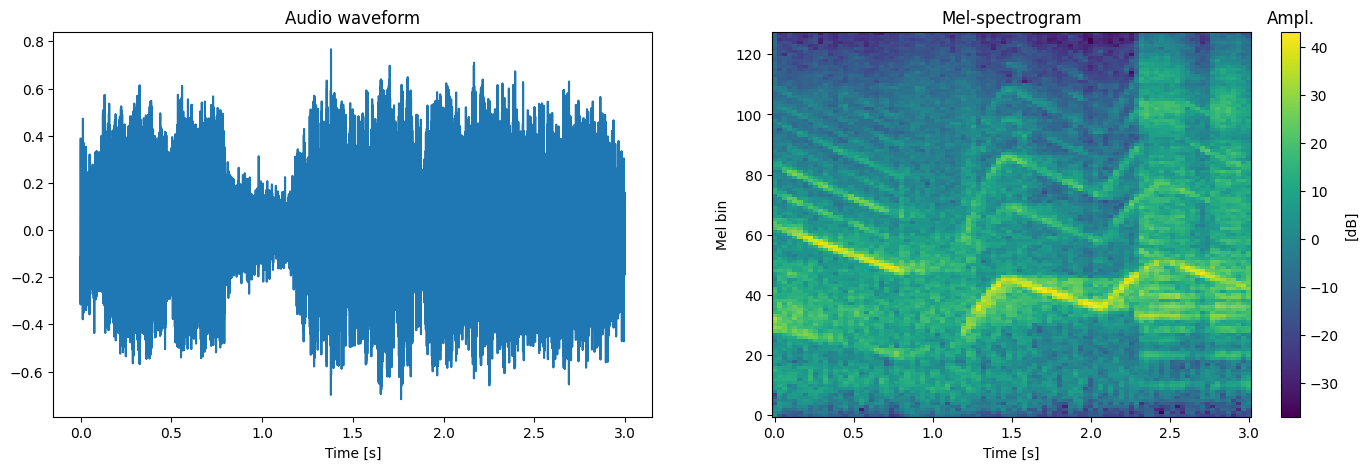

----------------------------------------------------------------------------------------------------
Playback


In [22]:
# Load signa: use index 0, 3, 8 for noise, index 59, 63, 65 for siren (and try to change them as well!)
signal, original_sr = torchaudio.load(df_test.loc[59, 'file_path'])  

print('Original signal')
print(f'Size of signal file [channels, samples]: {list(signal.shape)}')
print(f'Sampling frequency: {original_sr} Hz')
print(f'Length of signal file: {signal.shape[1] / original_sr:.2f}s')
print('-' * 100)

# Resample signal
if original_sr != sample_rate:
    resampler = torchaudio.transforms.Resample(original_sr, sample_rate)
    signal = resampler(signal)

# If file contains more than one channel, convert to mono
if signal.shape[0] > 1:
        signal = signal[0, :]
if len(signal.shape) == 1:
        signal = signal[None, :]

print('Resampled signal')
print(f'Size of audio file [channels, samples]: {list(signal.shape)}')
print(f'Sampling frequency: {sample_rate} Hz')
print(f'Length of signal file: {signal.shape[1] / sample_rate:.2f}s')

print('-' * 100)

# Extract mel-spectrogram
mel_spec = db_scale(mel_spectrogram(signal))
print(f'Spectrogram shape [channels, mel_bins, t_frames]: {list(mel_spec.shape)}')

# Generate figure
fig, ax = plt.subplots(1,2, figsize=(17,5))

# Plot time-domain signal
ax[0].plot(torch.linspace(0, signal.shape[1]/sample_rate, signal.shape[1]), signal[0])
ax[0].set_title('Audio waveform')
ax[0].set_xlabel('Time [s]')

# Plot mel-spectrogram
time_axis = torch.linspace(0, signal.shape[1] / sample_rate, mel_spec.shape[2])
freq_axis = torch.arange(0,128,1)
im = ax[1].pcolormesh(time_axis, freq_axis, mel_spec[0])
ax[1].set_title('Mel-spectrogram')
ax[1].set_xlabel('Time [s]')
ax[1].set_ylabel('Mel bin')
clb = fig.colorbar(im)
clb.ax.set_title('Ampl.')
clb.ax.set_ylabel('[dB]')
plt.show()

print('-' * 100)
print('Playback')

# Play back recorded signal
IPython.display.display(Audio(signal, rate=sample_rate, normalize=True))

## Step 2: Data Preparation

Now that we have explored our data, we are ready to define what to do with our data during training and testing. More precisely, we need to define how to

- segment audio data,
- pre-process our audio data,
- load the data (i.e. feed individual samples) during training and testing.

### 2.1. Audio Data Segmentation

When we explored the data in the previous step, we have looked at entire audio files of various lengths. However, we would like our classifier to detect sirens given audio segments of a fixed, relatively short length. After all, in practice, we wouldn't want to wait 8 seconds or so to detect a siren. Therefore, we segment the data into pieces of 1s. The start and end points are defined in a different .cvs file, namely **df_nature_split_1s_segments.csv** (generated by dataset_preparation.py).

#### To Do:
- Have a look at the code in the cell below and understand what it does. 
- Verify that the segments in df_train are shuffled. 
- During training, return here and study the effect of num_train_samples. Note down the accuracy and the number of training samples you have used. With this, you could for instance plot the accuracy vs. the number of training samples.



In [23]:
# Read the data file: the data has been split in 1s segments to be fed to the neural network

# All the segments of the same file are assigned to the same data subset (train, validation or test): this way the validation and test data are not overlapped with the training set (this would in fact contaminate the metrics)

# The parameter num_train_samples can be used to vary the number of samples of the training set. We can try to increase it to see how the dataset size impacts the model performance
df = pd.read_csv('dataset/df_nature_split_1s_segments.csv', index_col=0)

# Look into dataset structure and content (first 16 elements)
display(df.head(16))

# randomly sample the table
df = df.sample(frac=1, random_state=4703).reset_index(drop=True, inplace=False)

# Look into dataset structure and content (first 16 elements)

# Retrieve train, validation and test sets
df_train = df[df['split'] == 'train']
df_train = df_train.sample(frac=1, random_state=4703).reset_index(drop=True, inplace=False)
df_train = df_train[:min(len(df_train), num_train_samples)]

df_validation = df[df['split'] == 'validation']
df_validation = df_validation.sample(frac=1, random_state=4703).reset_index(drop=True, inplace=False)

df_test = df[df['split'] == 'test']
df_test = df_test.sample(frac=1, random_state=4703).reset_index(drop=True, inplace=False)

,file_path,file_class,file_duration,split,audio_start,audio_end
0,dataset/noise/road363.wav,noise,9.96,train,0.0,1.0
1,dataset/noise/road363.wav,noise,9.96,train,1.0,2.0
2,dataset/noise/road363.wav,noise,9.96,train,2.0,3.0
3,dataset/noise/road363.wav,noise,9.96,train,3.0,4.0
4,dataset/noise/road363.wav,noise,9.96,train,4.0,5.0
5,dataset/noise/road363.wav,noise,9.96,train,5.0,6.0
6,dataset/noise/road363.wav,noise,9.96,train,6.0,7.0
7,dataset/noise/road363.wav,noise,9.96,train,7.0,8.0
8,dataset/noise/road363.wav,noise,9.96,train,8.0,9.0
9,dataset/noise/road377.wav,noise,9.58,train,0.0,1.0


### 2.2. Audio Data Pre-processing and Data Loading 

Next, we have to define how to preprocess our audio data in order to generate samples for training, and how to feed individual samples during training epochs. This is done using the SirenDataset class in dataloader.py, and the DataLoader class from torch.utils.data.

#### To Do:
- Have a look at the code in the cell below and understand what it does. 
- Also have a look into dataset.py.

In [24]:
# Define feature extraction pipeline
feature_extraction = torch.nn.Sequential(
    mel_spectrogram,
    db_scale
)

# Generate instances of class SirenDataset, which defines how to load audio, convert to mono, resample, perform normalization, and retrieve the label. 
train_data = SirenDataset(df_train, sample_rate, transforms=feature_extraction)
validation_data = SirenDataset(df_validation, sample_rate, transforms=feature_extraction)
test_data = SirenDataset(df_test, sample_rate, transforms=feature_extraction)

# The SirenDatasets will be used as an input to the iterable DataLoader, which defines how to create individual batches to be used per epoch (e.g., by defining the batch size, i.e. the number of audio samples) 
train_dataloader = DataLoader(
    train_data,
    batch_size=batch_size,
    shuffle=True,
    drop_last=True
)

validation_dataloader = DataLoader(
    validation_data,
    batch_size=batch_size,
    shuffle=False,
    drop_last=True
)

test_dataloader = DataLoader(
    test_data,
    batch_size=batch_size,
    shuffle=False,
    drop_last=True
)

## Step 3: Definition of the CNN Model

We have clarified what to do what our data, but what about the architecture of our CNN model? For this lab, we work with two models, which are defined in models.py. 

#### To Do:
- Have a look at the code in the cell below and understand what it does.
- Also have a look into models.py.
- During training, return here and study the effect of num_filters in VGGlikeNet and kernel_size in SpectrogramCNN on the size of the model and performance. Keep in mind that these parameters strongly impact the number of parameters of the model and therefore training time, so try to avoid extreme numbers. Note down the model size, the accuracy, and the num_filters you have used. With this, you could for instance plot the accuracy vs. model size for a few different models.


In [29]:
# Instantiate model, define optimizer and loss function (Uncomment the desired model)
# model = VGGlikeNet(num_filters = [4, 8, 16])
model = SpectrogramCNN(num_filters = [6, 16, 120])

model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_func = torch.nn.CrossEntropyLoss()

# Print model information
torchinfo.summary(model, (batch_size,1,n_mels,math.ceil(1 / hop_len)))

Layer (type:depth-idx)                   Output Shape              Param #
SpectrogramCNN                           [32, 2]                   --
├─Conv2d: 1-1                            [32, 6, 128, 32]          156
├─Conv2d: 1-2                            [32, 16, 64, 16]          2,416
├─Conv2d: 1-3                            [32, 120, 32, 8]          48,120
├─Flatten: 1-4                           [32, 7680]                --
├─Linear: 1-5                            [32, 84]                  645,204
├─Linear: 1-6                            [32, 2]                   170
Total params: 696,066
Trainable params: 696,066
Non-trainable params: 0
Total mult-adds (M): 514.47
Input size (MB): 0.52
Forward/backward pass size (MB): 18.37
Params size (MB): 2.78
Estimated Total Size (MB): 21.68

## Step 4: Model Training and Testing

Now we are ready to training and testing the model and study its performance!

#### To Do:
- Have a look at the code in the cell below and understand what it does.
- Also have a look into loop.py.
- Explore training with different models with a different number of training samples as outlined in the previous cells. For comparison, note down relevant metrics such as the number of training samples, the number of parameters in the model, and the accuracy.
- Enjoy the break while waiting :-)

Epoch 1/12: 100%|██████████████████████████████████████| 31/31 [00:18<00:00,  1.66step/s, loss=0.533, accuracy=0.714]


Epoch end: train_loss: 0.5331 - train_acc: 0.7080 - val_loss: 0.4330 - val_acc: 0.7748


Epoch 2/12: 100%|██████████████████████████████████████| 31/31 [00:18<00:00,  1.67step/s, loss=0.297, accuracy=0.884]


Epoch end: train_loss: 0.2967 - train_acc: 0.8770 - val_loss: 0.2385 - val_acc: 0.9067


Epoch 3/12: 100%|██████████████████████████████████████| 31/31 [00:18<00:00,  1.66step/s, loss=0.169, accuracy=0.957]


Epoch end: train_loss: 0.1688 - train_acc: 0.9490 - val_loss: 0.1495 - val_acc: 0.9229


Epoch 4/12: 100%|███████████████████████████████████████| 31/31 [00:18<00:00,  1.66step/s, loss=0.118, accuracy=0.97]


Epoch end: train_loss: 0.1176 - train_acc: 0.9620 - val_loss: 0.1112 - val_acc: 0.9290


Epoch 5/12: 100%|█████████████████████████████████████| 31/31 [00:18<00:00,  1.64step/s, loss=0.0796, accuracy=0.975]


Epoch end: train_loss: 0.0796 - train_acc: 0.9670 - val_loss: 0.0835 - val_acc: 0.9493


Epoch 6/12: 100%|█████████████████████████████████████| 31/31 [00:21<00:00,  1.45step/s, loss=0.0731, accuracy=0.978]


Epoch end: train_loss: 0.0731 - train_acc: 0.9700 - val_loss: 0.0693 - val_acc: 0.9513


Epoch 7/12: 100%|█████████████████████████████████████| 31/31 [00:25<00:00,  1.24step/s, loss=0.0531, accuracy=0.985]


Epoch end: train_loss: 0.0531 - train_acc: 0.9770 - val_loss: 0.0797 - val_acc: 0.9473


Epoch 8/12: 100%|█████████████████████████████████████| 31/31 [00:29<00:00,  1.04step/s, loss=0.0415, accuracy=0.985]


Epoch end: train_loss: 0.0415 - train_acc: 0.9770 - val_loss: 0.0697 - val_acc: 0.9554


Epoch 9/12: 100%|█████████████████████████████████████| 31/31 [00:24<00:00,  1.28step/s, loss=0.0436, accuracy=0.989]


Epoch end: train_loss: 0.0436 - train_acc: 0.9810 - val_loss: 0.0773 - val_acc: 0.9513


Epoch 10/12: 100%|█████████████████████████████████████| 31/31 [00:20<00:00,  1.53step/s, loss=0.045, accuracy=0.989]


Epoch end: train_loss: 0.0450 - train_acc: 0.9810 - val_loss: 0.0713 - val_acc: 0.9574


Epoch 11/12: 100%|████████████████████████████████████| 31/31 [00:19<00:00,  1.60step/s, loss=0.0386, accuracy=0.986]


Epoch end: train_loss: 0.0386 - train_acc: 0.9780 - val_loss: 0.0438 - val_acc: 0.9615


Epoch 12/12: 100%|████████████████████████████████████| 31/31 [00:19<00:00,  1.56step/s, loss=0.0481, accuracy=0.983]


Epoch end: train_loss: 0.0481 - train_acc: 0.9750 - val_loss: 0.0558 - val_acc: 0.9574
test_loss: 0.0306 - test_acc: 0.9648


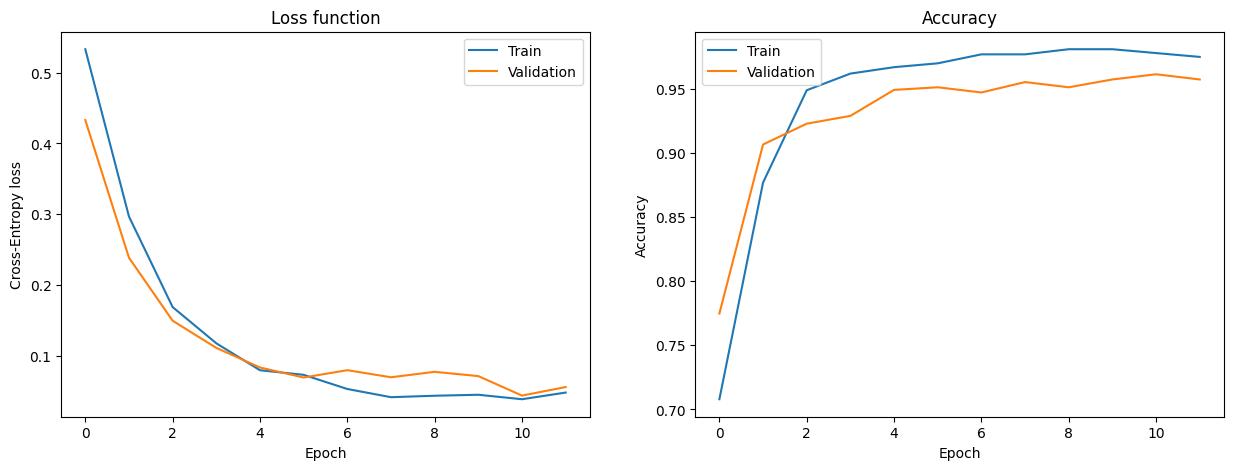

In [28]:
# init metrics
metrics = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': []
}

# Perform training
for i in range(num_epochs):
    train_loss, train_acc = train_loop(train_dataloader, model, optimizer, loss_func, i+1, num_epochs, device)
    val_loss, val_acc = val_loop(validation_dataloader, model, loss_func, device)
    metrics['train_loss'].append(train_loss)
    metrics['train_acc'].append(train_acc)
    metrics['val_loss'].append(val_loss)
    metrics['val_acc'].append(val_acc)
    print(f'Epoch end: train_loss: {train_loss:.4f} - train_acc: {train_acc:.4f} - val_loss: {val_loss:.4f} - val_acc: {val_acc:.4f}')

# Plot training curves
fig, ax = plt.subplots(1,2, figsize=(15,5))

ax[0].plot(metrics['train_loss'])
ax[0].plot(metrics['val_loss'])
ax[0].set_title('Loss function')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Cross-Entropy loss')
ax[0].legend(['Train', 'Validation'])


ax[1].plot(metrics['train_acc'])
ax[1].plot(metrics['val_acc'])
ax[1].set_title('Accuracy')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
ax[1].legend(['Train', 'Validation']);

# Run evaluation on test data
test_loss, test_acc = val_loop(test_dataloader, model, loss_func, device)
print(f'test_loss: {test_loss:.4f} - test_acc: {test_acc:.4f}')

## Acknowledgements

This tutorial would not have been possible without the commitment of Stefano Damiano, who prepared the code for this Jupyter Notebook based on his own research.

## References

[1] M. Asif, M. Usaid, M. Rashid, T. Rajab, S. Hussain, S. Wasi, "Large-scale audio dataset for emergency vehicle sirens and road noises," Scientific Data vol. 9, article no. 599, pp. 1-9, 2022.

[2] M. Cantarini, A. Brocanelli, L. Gabrielli, and S. Squartini, "Acoustic Features for Deep Learning-Based Models for Emergency Siren Detection: An Evaluation Study," in 2021 12th International Symposium on Image and Signal Processing and Analysis (ISPA), Zagreb, Croatia, 2021, pp. 47–53.

[3] Y. LeCun, L. Bottou, Y. Bengio, P. Haffner, "Gradient-based learning applied to document recognition," in Proceedings of the IEEE, vol. 86, no. 11, pp. 2278-2324, 1998.